In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt#; plt.rcParams['figure.dpi'] = 200

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print("Loading MNIST dataset...")
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

Loading MNIST dataset...


In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, pic_channels=1):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=pic_channels, out_channels=latent_dims//2, kernel_size=4)
        self.conv2 = nn.Conv2d(in_channels=latent_dims//2, out_channels=latent_dims, kernel_size=4)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        #print(x)
        return x

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, pic_channels=1):
        super(Decoder, self).__init__()
        self.conv_trans1 = nn.ConvTranspose2d(in_channels=latent_dims, out_channels=latent_dims//2, kernel_size=4)
        self.conv_trans2 = nn.ConvTranspose2d(in_channels=latent_dims//2, out_channels=pic_channels, kernel_size=4)

    def forward(self, x):
        x = self.conv_trans1(x)
        x = F.relu(x)
        x = self.conv_trans2(x)
        return x

In [6]:
class VectorQuantizer(nn.Module):
    def __init__(self, latent_dims, num_codes=32, beta=0.25):
        super(VectorQuantizer, self).__init__()
        self.K = num_codes
        self.D = latent_dims
        self.beta = beta

        self.codebook = nn.Embedding(self.K, self.D)
        self.codebook.weight.data.uniform_(-1 / self.K, 1 / self.K)

        self.vq_loss = 0

    def forward(self, latents):
        '''
         latents: (batch, dim, height, width)
         codebook: (K, dim)
        '''
        # convert latents from BCHW -> BHWC
        latents = latents.permute(0, 2, 3, 1).contiguous() # (B, H, W, dim)
        latents_shape = latents.shape
        
        # Flatten latent
        flat_latent = latents.view(-1, self.D) # (BHW, dim)

        # Compute L2 distance between latents and codes in codebook
        dist = (flat_latent.unsqueeze(1) - self.codebook.weight.unsqueeze(0)) ** 2 # (BHW, 1, dim) - (1, K, dim) -> (BHW, K, dim)
        dist = dist.sum(-1) # (BHW, K)

        # Get the code index that has the min distance
        nearest_idxs = torch.argmin(dist, dim=1).unsqueeze(1)  # (BHW, 1)

        # Convert to one-hot
        nearest_one_hot = torch.zeros(nearest_idxs.size(0), self.K, device=latents.device) # (BHW, K)
        nearest_one_hot.scatter_(1, nearest_idxs, 1)  # .scatter(dim,index,src)

        # Quantize the latents
        quantized_latents = torch.matmul(nearest_one_hot, self.codebook.weight).view(latents_shape) # (BHW, K) * (K, dim) = (BHW, dim) -> (B, H, W, dim)

        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized_latents.detach(), latents)
        codebook_loss = F.mse_loss(quantized_latents, latents.detach())

        self.vq_loss = commitment_loss * self.beta + codebook_loss

        # convert quantized from BHWC -> BCHW
        quantized_latents = latents + (quantized_latents - latents).detach()
        return quantized_latents.permute(0, 3, 1, 2).contiguous()

In [ ]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, latent_dims, num_codes=32, beta=0.25, gamma=0.99, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        self.K = num_codes
        self.D = latent_dims
        self.beta = beta
        self.gamma = gamma
        self.epsilon = 1e-5

        self.codebook = nn.Embedding(self.K, self.D)
        self.codebook.weight.data.normal_()

        self.N = None
        self.m = None

        self.vq_loss = 0

    def forward(self, latents):
        '''
         latents: (batch, dim, height, width)
         codebook: (K, dim)
        '''
        # convert latents from BCHW -> BHWC
        latents = latents.permute(0, 2, 3, 1).contiguous() # (B, H, W, dim)
        latents_shape = latents.shape
        
        # Flatten latent
        flat_latent = latents.view(-1, self.D) # (BHW, dim)

        # Compute L2 distance between latents and codes in codebook
        dist = (flat_latent.unsqueeze(1) - self.codebook.weight.unsqueeze(0)) ** 2 # (BHW, 1, dim) - (1, K, dim) -> (BHW, K, dim)
        dist = dist.sum(-1) # (BHW, K)

        # Get the code index that has the min distance
        nearest_idxs = torch.argmin(dist, dim=1).unsqueeze(1)  # (BHW, 1)

        # Convert to one-hot
        nearest_one_hot = torch.zeros(nearest_idxs.size(0), self.K, device=latents.device) # (BHW, K)
        nearest_one_hot.scatter_(1, nearest_idxs, 1)  # .scatter(dim,index,src)

        # Quantize the latents
        quantized_latents = torch.matmul(nearest_one_hot, self.codebook.weight).view(latents_shape) # (BHW, K) * (K, dim) = (BHW, dim) -> (B, H, W, dim)

        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized_latents.detach(), latents)
        self.vq_loss = commitment_loss * self.beta

        # EMA update cookbook
        n = torch.sum(nearest_one_hot, 0) # (K)
        self.N = self.N * self.gamma + (1 - self.gamma) * n if self.N is not None else n
        N_ = torch.sum(self.N.data) # Laplace smoothing of the cluster size
        self.N = (self.N + self.epsilon) / (N_ + self.K * self.epsilon) * N_
        z = torch.matmul(nearest_one_hot.T, flat_latent) # (K, BHW) * (BHW, dim) = (K, dim)
        self.m = nn.Parameter(self.m * self.gamma + (1 - self.gamma) * z) if self.m is not None else nn.Parameter(z)
        self.codebook.weight = nn.Parameter(self.m / self.N.unsqueeze(1))
        
        # convert quantized from BHWC -> BCHW
        quantized_latents = latents + (quantized_latents - latents).detach()
        return quantized_latents.permute(0, 3, 1, 2).contiguous()

In [7]:
class VQVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, ema=True):
        super(VQVariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        if ema:
          self.vector_quantizer = VectorQuantizerEMA(latent_dims)
        else:
          self.vector_quantizer = VectorQuantizer(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z_e = self.encoder(x)
        z_q = self.vector_quantizer(z_e) # (batch, dim, 22, 22)
        return self.decoder(z_q)

In [8]:
def plot_codebook(autoencoder):
    codes = autoencoder.vector_quantizer.codebook.weight.detach().cpu().numpy()
    for i in range(codes.shape[0]):
        plt.scatter(codes[i][0], codes[i][1])
    plt.show()

In [9]:
def plot_recon(autoencoder, data, n=10):
    x = next(iter(data))[0][:n]
    x_hat = autoencoder(x.to(device))
    x_hat = x_hat.to('cpu').detach().numpy().squeeze(1)

    w = x_hat.shape[1]
    img = np.zeros((w, n*w))

    print("original:")
    for i in range(x_hat.shape[0]):
      img[:, i*w:(i+1)*w] = x[i]
    plt.imshow(img)
    plt.show()

    print("reconstructed:")
    for i in range(x_hat.shape[0]):
      img[:, i*w:(i+1)*w] = x_hat[i]
    plt.imshow(img)
    plt.show()

In [10]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}/{epochs}")
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.vector_quantizer.vq_loss
            loss.backward()
            opt.step()
        plot_codebook(autoencoder)
        plot_recon(autoencoder, data)
    return autoencoder

epoch: 1/20


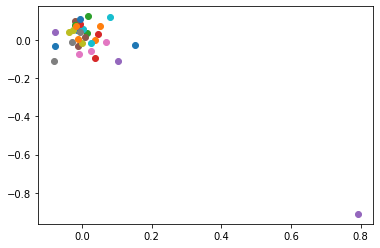

original:


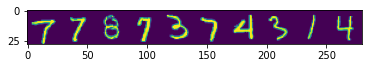

reconstructed:


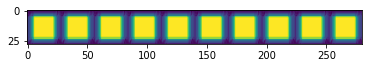

epoch: 2/20


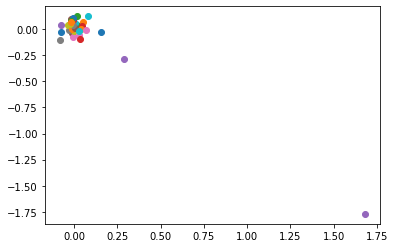

original:


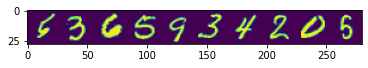

reconstructed:


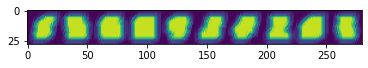

epoch: 3/20


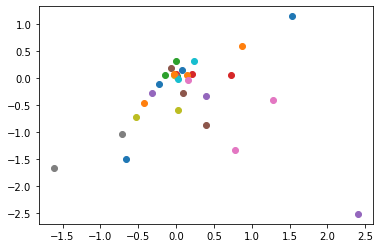

original:


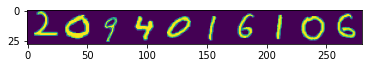

reconstructed:


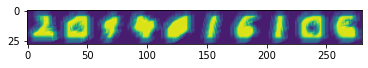

epoch: 4/20


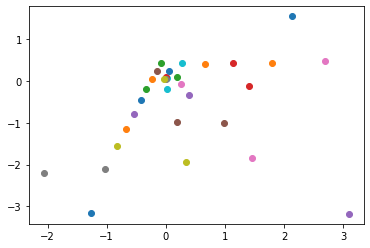

original:


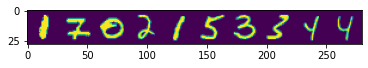

reconstructed:


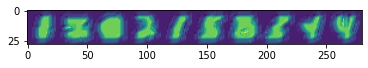

epoch: 5/20


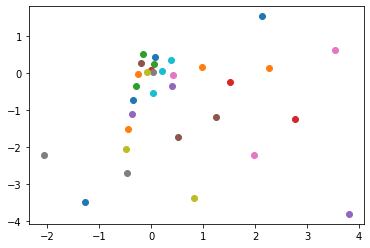

original:


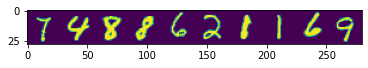

reconstructed:


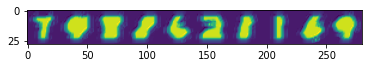

epoch: 6/20


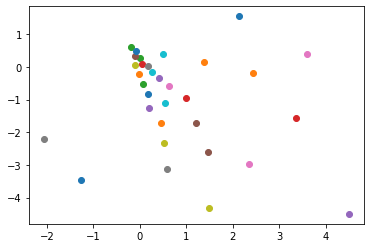

original:


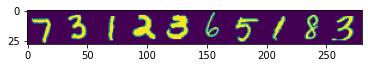

reconstructed:


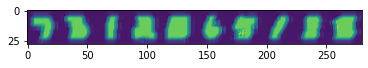

epoch: 7/20


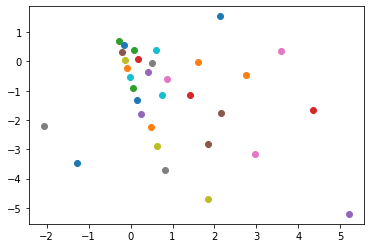

original:


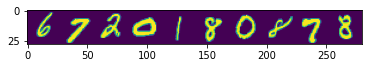

reconstructed:


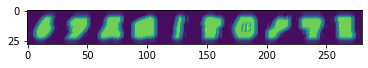

epoch: 8/20


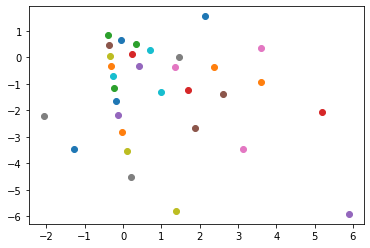

original:


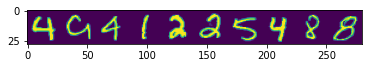

reconstructed:


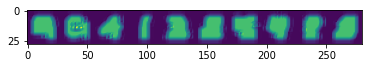

epoch: 9/20


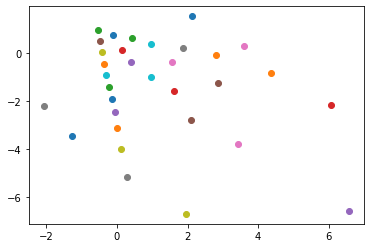

original:


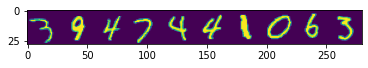

reconstructed:


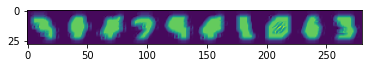

epoch: 10/20


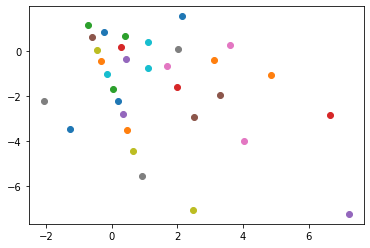

original:


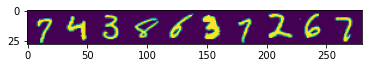

reconstructed:


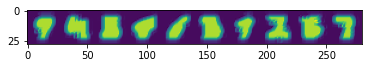

epoch: 11/20


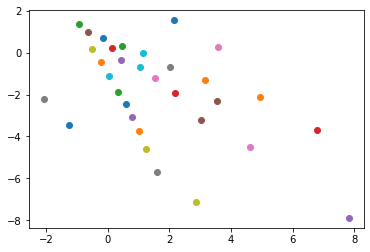

original:


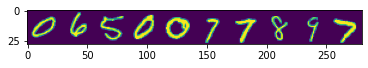

reconstructed:


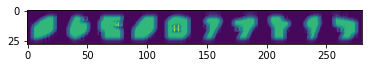

epoch: 12/20


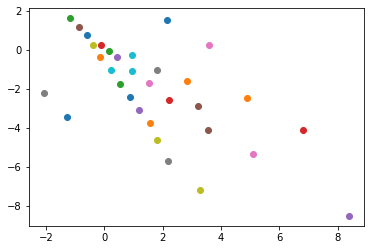

original:


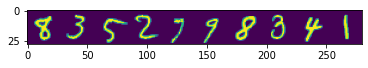

reconstructed:


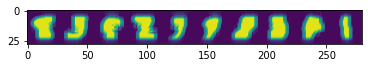

epoch: 13/20


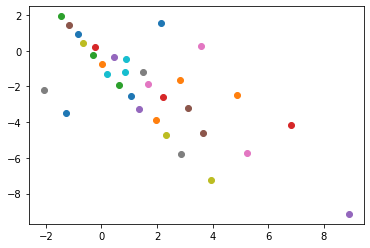

original:


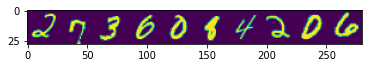

reconstructed:


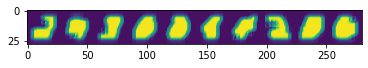

epoch: 14/20


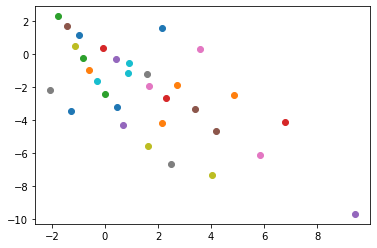

original:


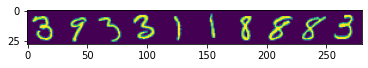

reconstructed:


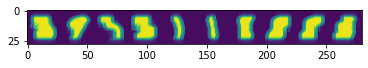

epoch: 15/20


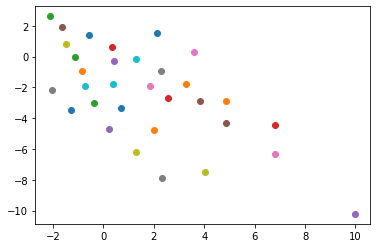

original:


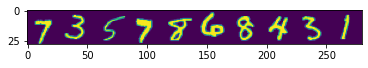

reconstructed:


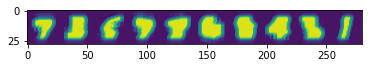

epoch: 16/20


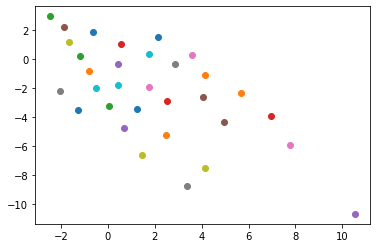

original:


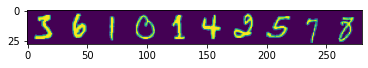

reconstructed:


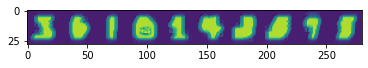

epoch: 17/20


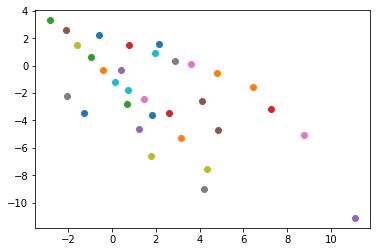

original:


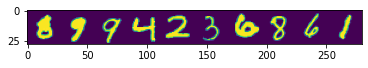

reconstructed:


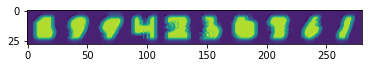

epoch: 18/20


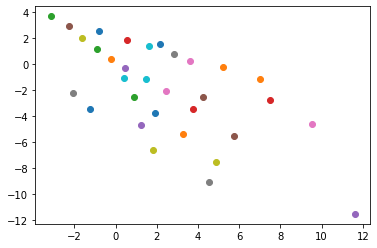

original:


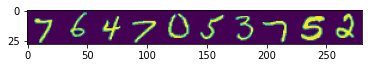

reconstructed:


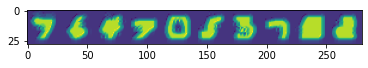

epoch: 19/20


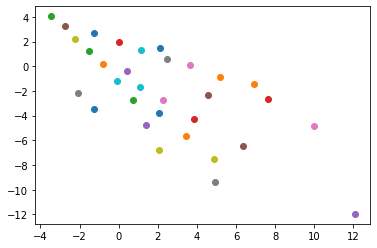

original:


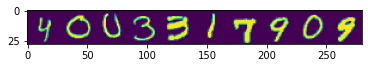

reconstructed:


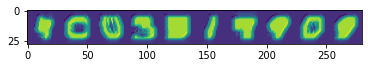

epoch: 20/20


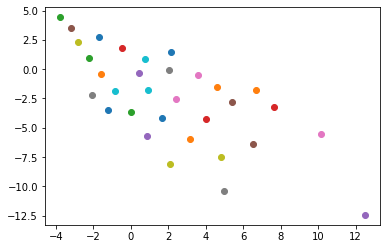

original:


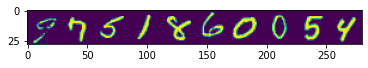

reconstructed:


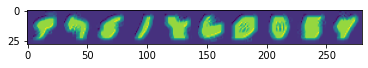

In [11]:
vqvae = VQVariationalAutoencoder(latent_dims=2, ema=False).to(device) # GPU
vqvae = train(vqvae, data)

epoch: 1/20


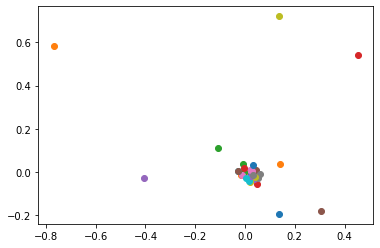

original:


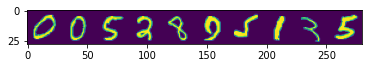

reconstructed:


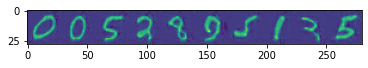

epoch: 2/20


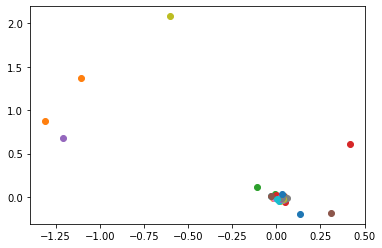

original:


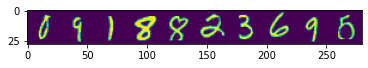

reconstructed:


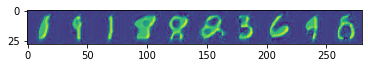

epoch: 3/20


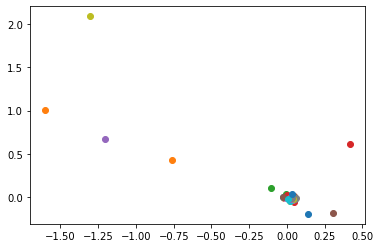

original:


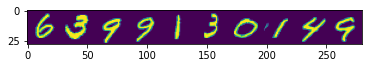

reconstructed:


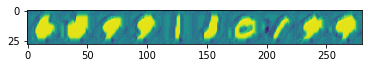

epoch: 4/20


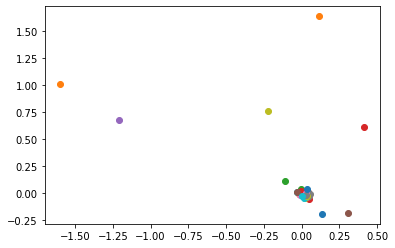

original:


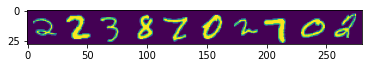

reconstructed:


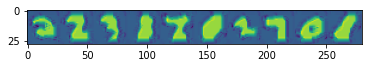

epoch: 5/20


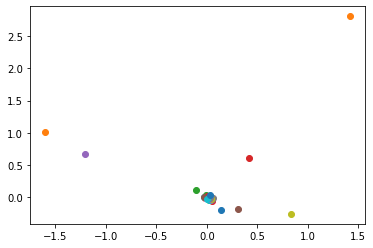

original:


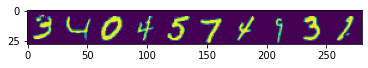

reconstructed:


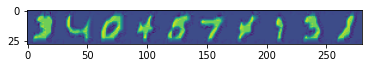

epoch: 6/20


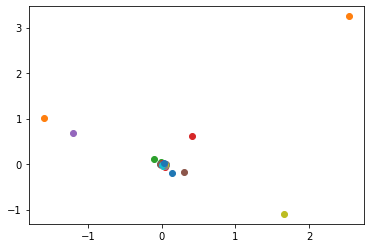

original:


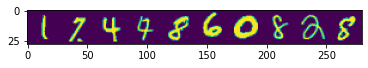

reconstructed:


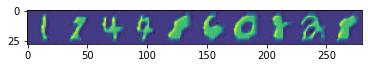

epoch: 7/20


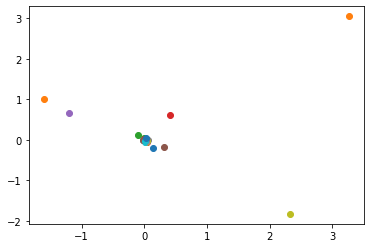

original:


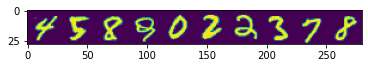

reconstructed:


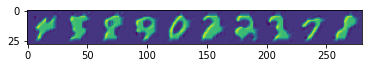

epoch: 8/20


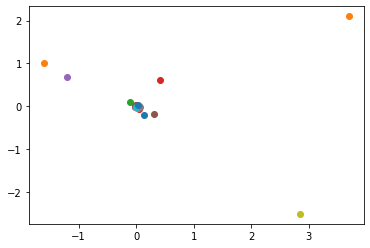

original:


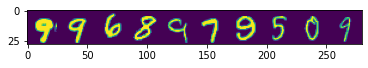

reconstructed:


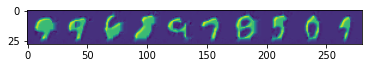

epoch: 9/20


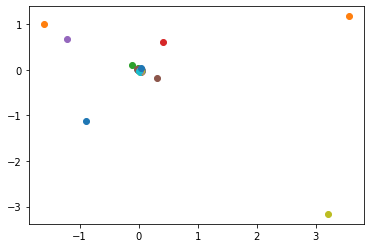

original:


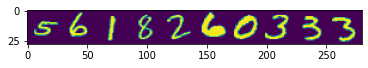

reconstructed:


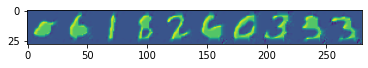

epoch: 10/20


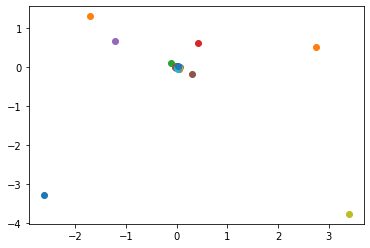

original:


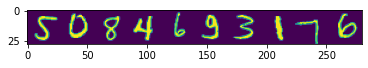

reconstructed:


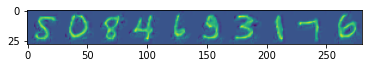

epoch: 11/20


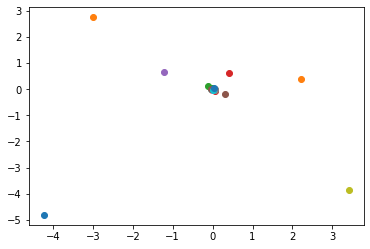

original:


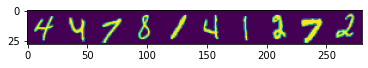

reconstructed:


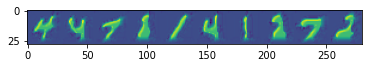

epoch: 12/20


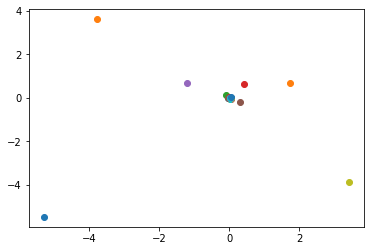

original:


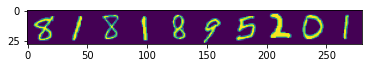

reconstructed:


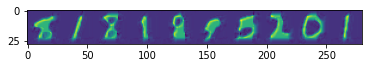

epoch: 13/20


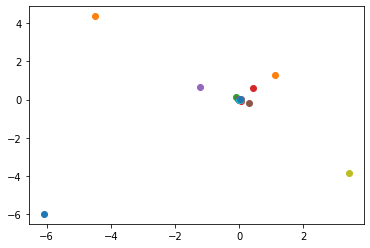

original:


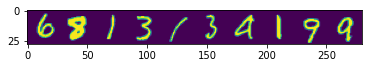

reconstructed:


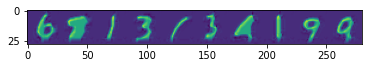

epoch: 14/20


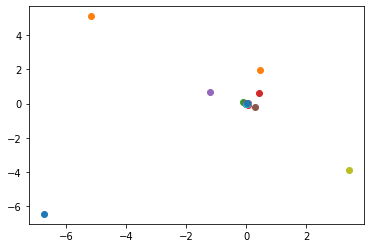

original:


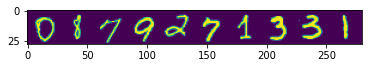

reconstructed:


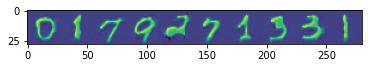

epoch: 15/20


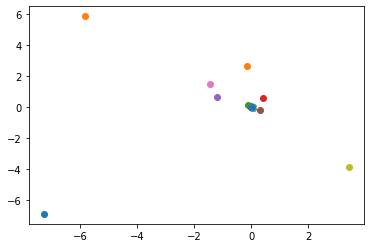

original:


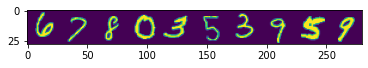

reconstructed:


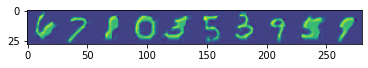

epoch: 16/20


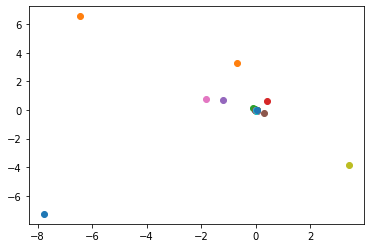

original:


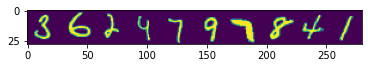

reconstructed:


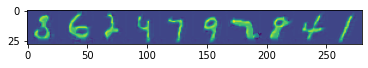

epoch: 17/20


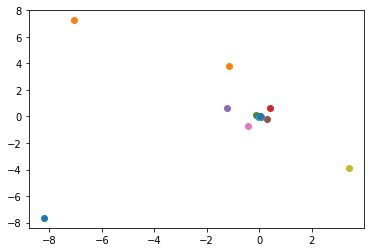

original:


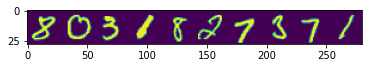

reconstructed:


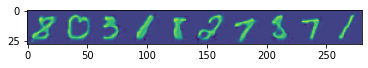

epoch: 18/20


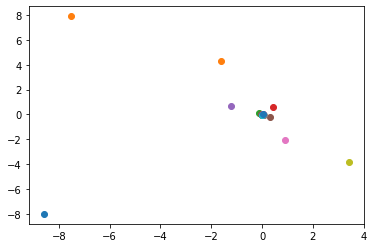

original:


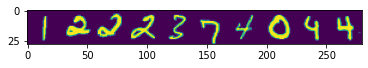

reconstructed:


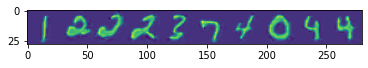

epoch: 19/20


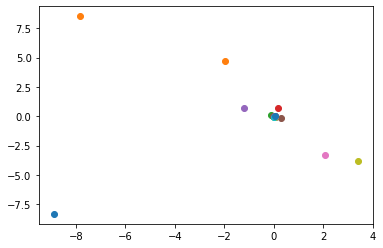

original:


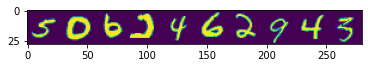

reconstructed:


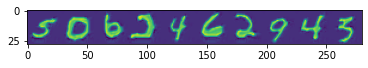

epoch: 20/20


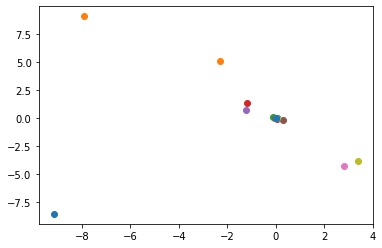

original:


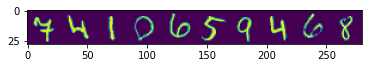

reconstructed:


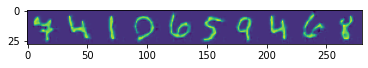

In [15]:
vqvae = VQVariationalAutoencoder(latent_dims=32, ema=False).to(device) # GPU
vqvae = train(vqvae, data)

epoch: 1/20


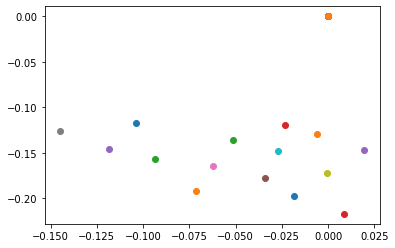

original:


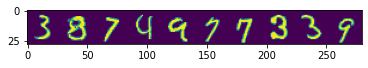

reconstructed:


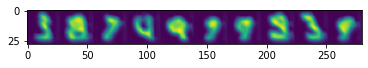

epoch: 2/20


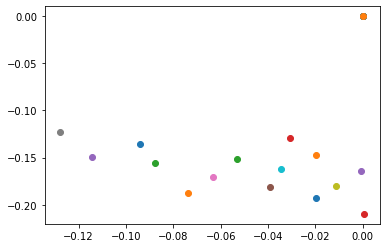

original:


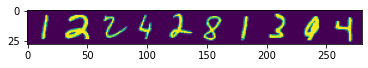

reconstructed:


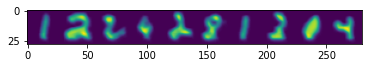

epoch: 3/20


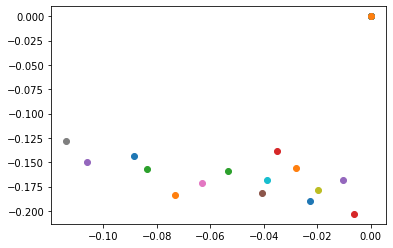

original:


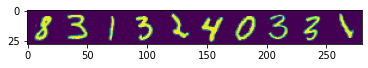

reconstructed:


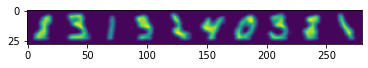

epoch: 4/20


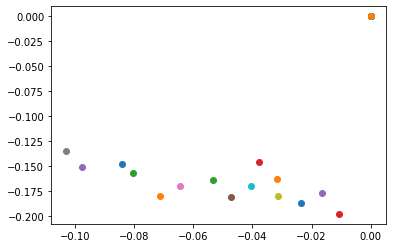

original:


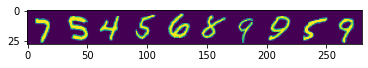

reconstructed:


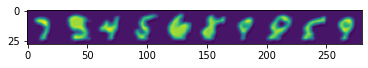

epoch: 5/20


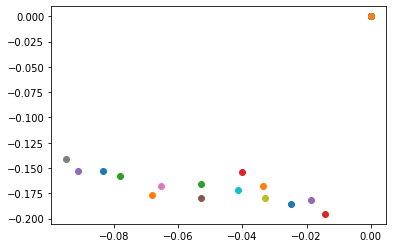

original:


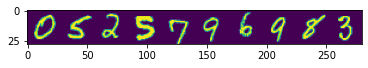

reconstructed:


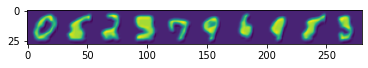

epoch: 6/20


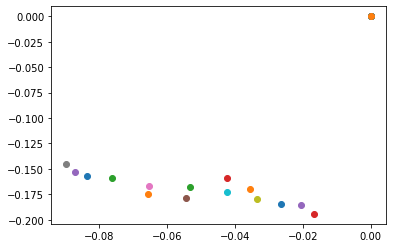

original:


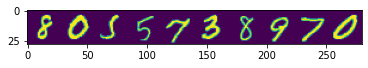

reconstructed:


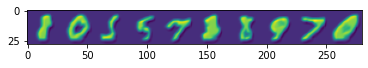

epoch: 7/20


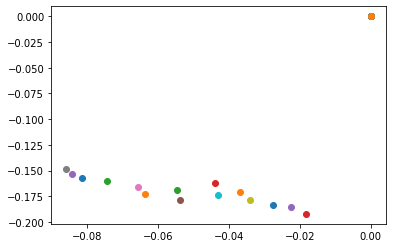

original:


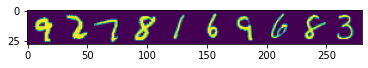

reconstructed:


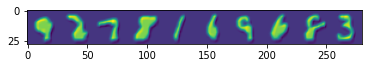

epoch: 8/20


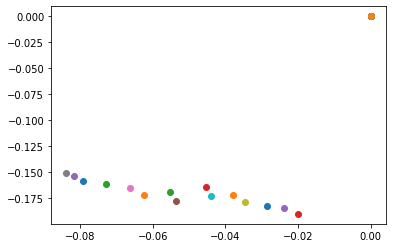

original:


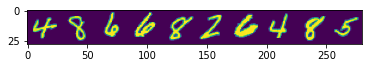

reconstructed:


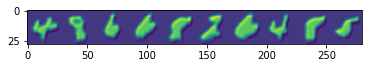

epoch: 9/20


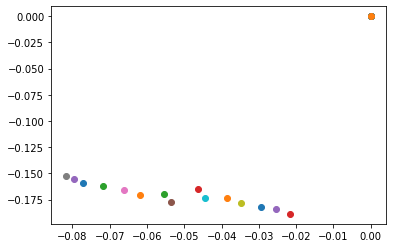

original:


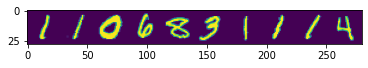

reconstructed:


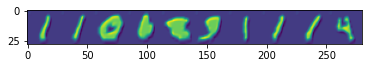

epoch: 10/20


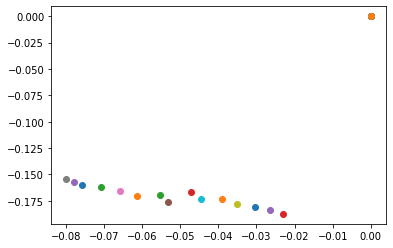

original:


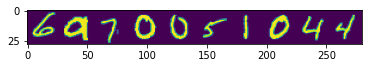

reconstructed:


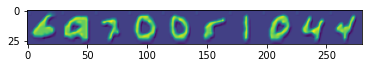

epoch: 11/20


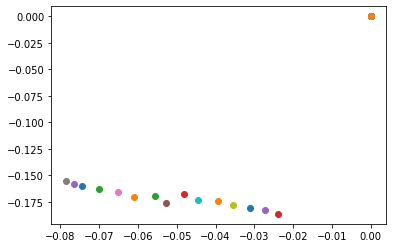

original:


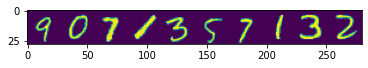

reconstructed:


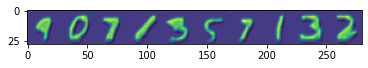

epoch: 12/20


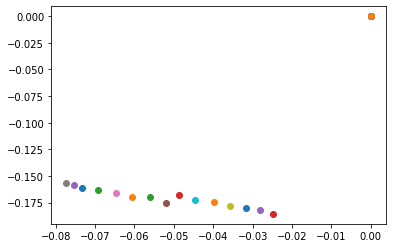

original:


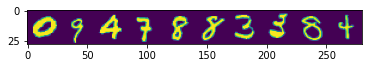

reconstructed:


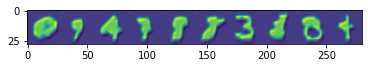

epoch: 13/20


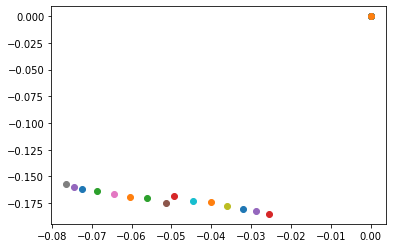

original:


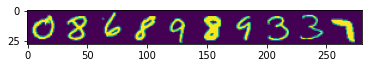

reconstructed:


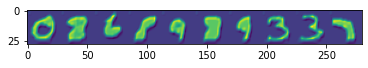

epoch: 14/20


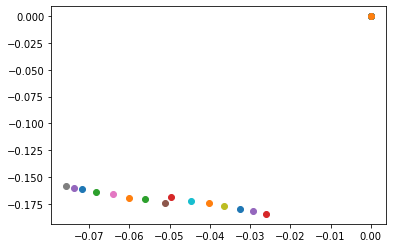

original:


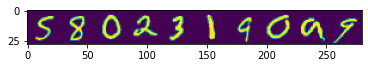

reconstructed:


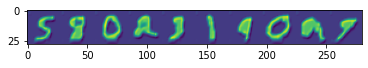

epoch: 15/20


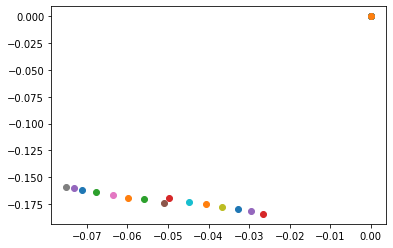

original:


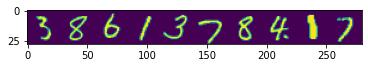

reconstructed:


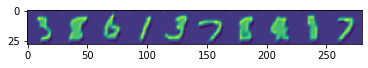

epoch: 16/20


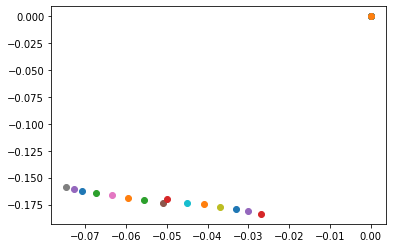

original:


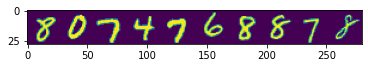

reconstructed:


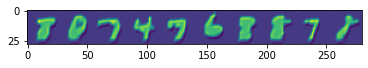

epoch: 17/20


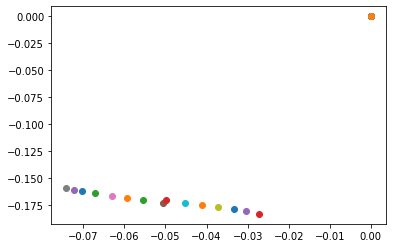

original:


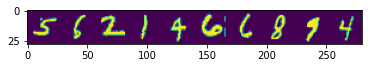

reconstructed:


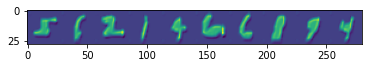

epoch: 18/20


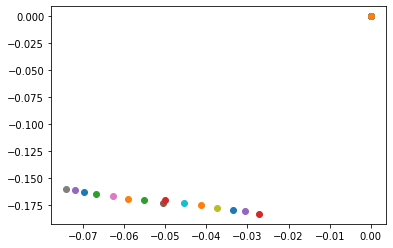

original:


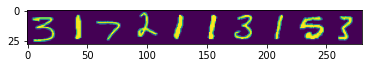

reconstructed:


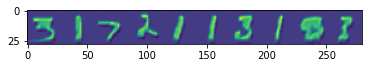

epoch: 19/20


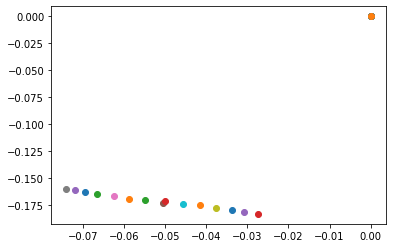

original:


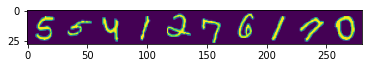

reconstructed:


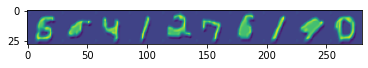

epoch: 20/20


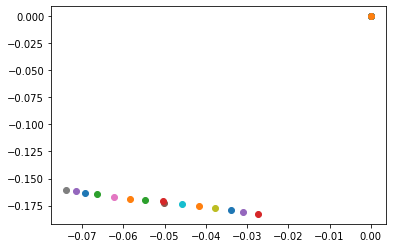

original:


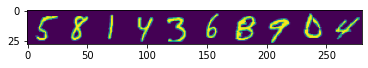

reconstructed:


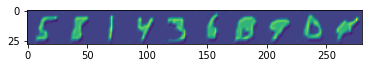

In [14]:
vqvae = VQVariationalAutoencoder(latent_dims=2, ema=True).to(device) # GPU
vqvae = train(vqvae, data)

epoch: 1/20


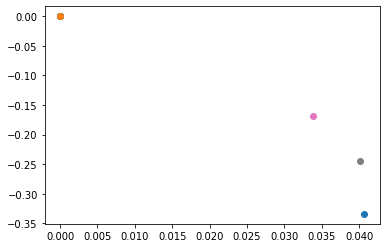

original:


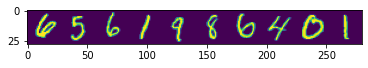

reconstructed:


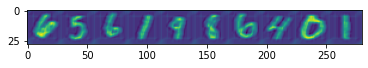

epoch: 2/20


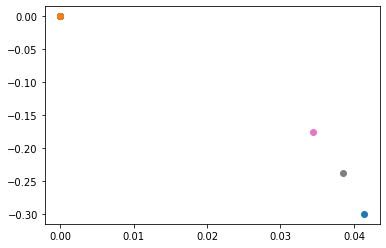

original:


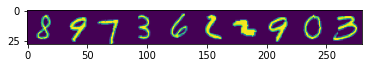

reconstructed:


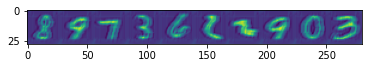

epoch: 3/20


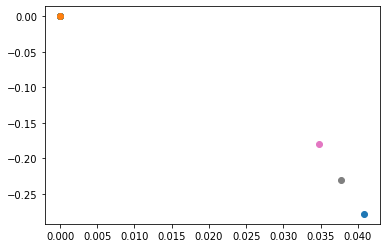

original:


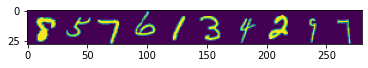

reconstructed:


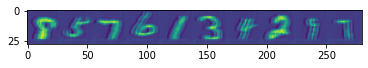

epoch: 4/20


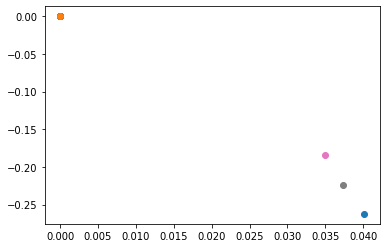

original:


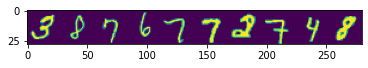

reconstructed:


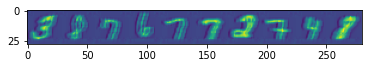

epoch: 5/20


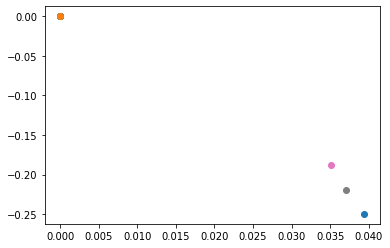

original:


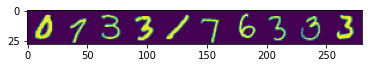

reconstructed:


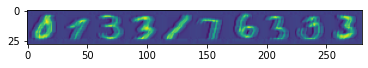

epoch: 6/20


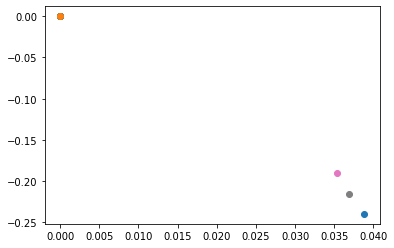

original:


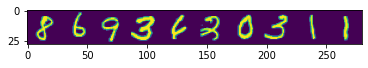

reconstructed:


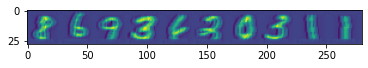

epoch: 7/20


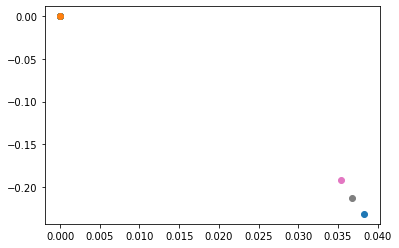

original:


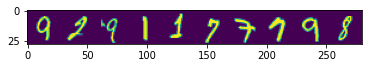

reconstructed:


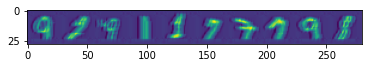

epoch: 8/20


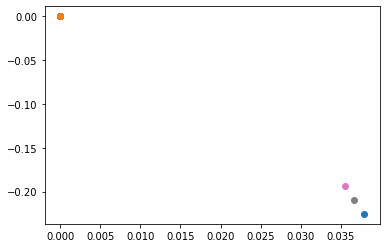

original:


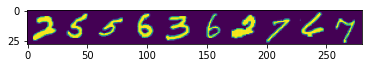

reconstructed:


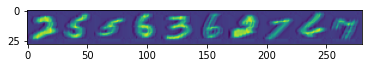

epoch: 9/20


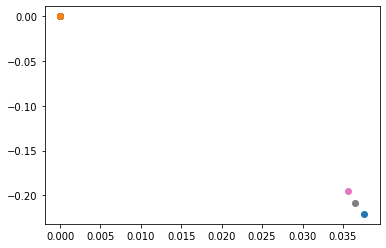

original:


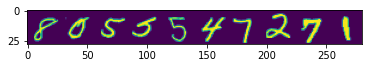

reconstructed:


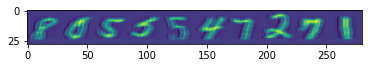

epoch: 10/20


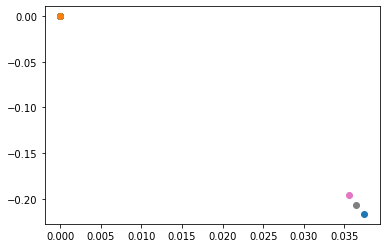

original:


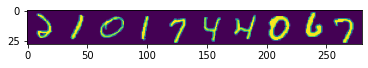

reconstructed:


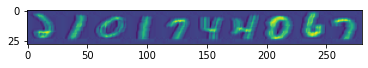

epoch: 11/20


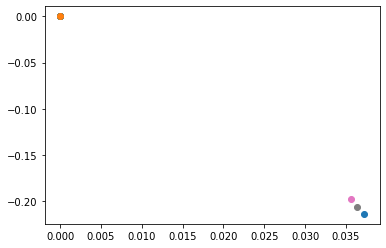

original:


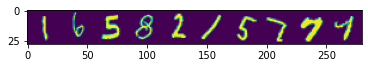

reconstructed:


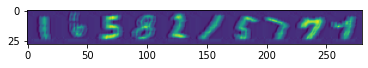

epoch: 12/20


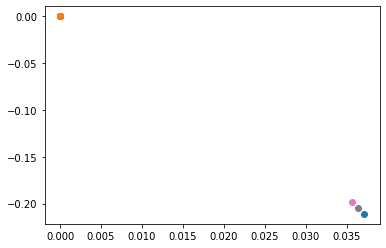

original:


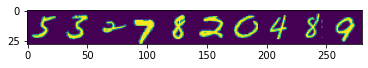

reconstructed:


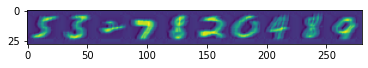

epoch: 13/20


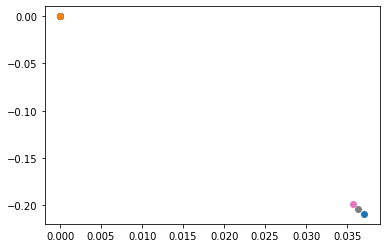

original:


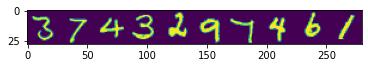

reconstructed:


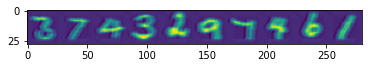

epoch: 14/20


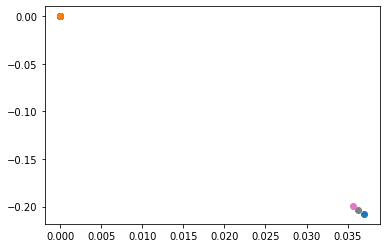

original:


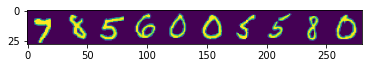

reconstructed:


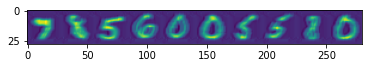

epoch: 15/20


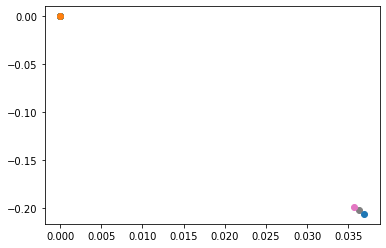

original:


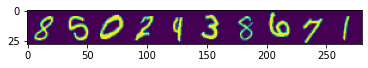

reconstructed:


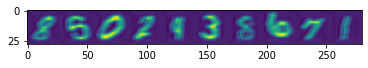

epoch: 16/20


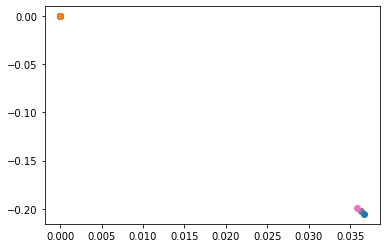

original:


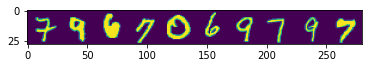

reconstructed:


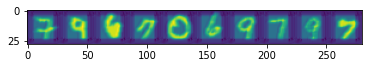

epoch: 17/20


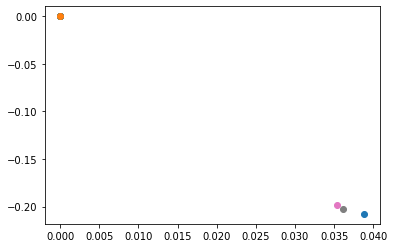

original:


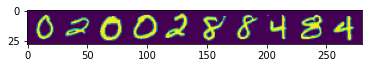

reconstructed:


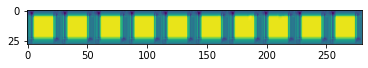

epoch: 18/20


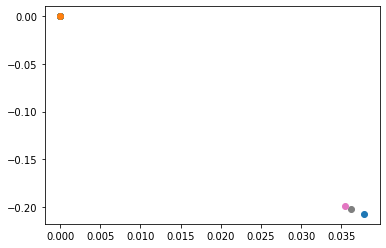

original:


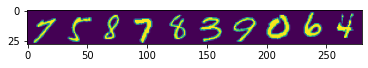

reconstructed:


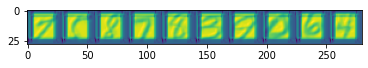

epoch: 19/20


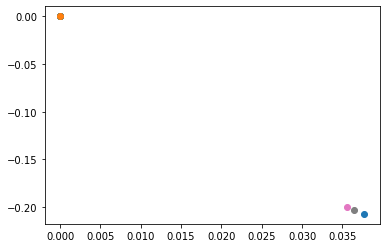

original:


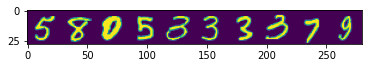

reconstructed:


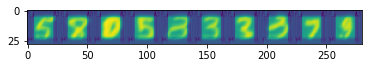

epoch: 20/20


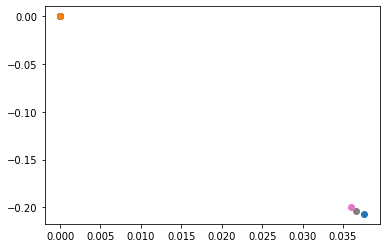

original:


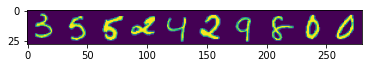

reconstructed:


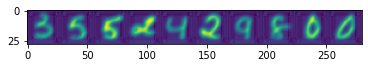

In [16]:
vqvae = VQVariationalAutoencoder(latent_dims=32, ema=True).to(device) # GPU
vqvae = train(vqvae, data)